# Netflix-Style Customer Churn Prediction

This notebook builds a simple machine learning model to predict which users are likely to churn from a Netflix-style streaming platform.

The data comes from the IBM Telco Customer Churn dataset, with columns renamed and slightly transformed to look like a streaming-service scenario. The model used is Logistic Regression, and the goal is to get a clean, easy-to-understand baseline with accuracy above 80%.


Original shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Streaming

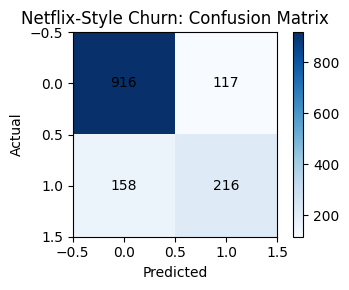

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

# === 1. LOAD DATA ===

df = pd.read_csv("data/telco_churn.csv")
print("Original shape:", df.shape)
print(df.head())

# === 2. RENAME COLUMNS TO NETFLIX STYLE ===

df = df.rename(columns={
    "tenure": "MonthsSubscribed",
    "MonthlyCharges": "MonthlySubscriptionFee",
    "TotalCharges": "TotalAmountPaid",
    "Contract": "PlanType",
    "InternetService": "StreamingQuality",
    "Churn": "Churned"
})

# Create synthetic "WatchHours" (engagement feature)
np.random.seed(42)
df["WatchHours"] = df["MonthsSubscribed"] * np.random.uniform(2, 6, size=len(df))

# === 3. CLEANING ===

# Convert TotalAmountPaid to numeric and drop rows with missing values
df['TotalAmountPaid'] = pd.to_numeric(df['TotalAmountPaid'], errors='coerce')
df = df.dropna(subset=['TotalAmountPaid'])

# Drop ID column (not useful for prediction)
if "customerID" in df.columns:
    df = df.drop("customerID", axis=1)

# Encode target: No -> 0, Yes -> 1
df["Churned"] = df["Churned"].map({"No": 0, "Yes": 1})

# === 4. FEATURE ENGINEERING ===

X = df.drop("Churned", axis=1)
y = df["Churned"]

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

print("Encoded shape:", X_encoded.shape)
print("Sample columns:", X_encoded.columns[:10])

# === 5. TRAIN-TEST SPLIT ===

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# === 6. SCALING ===

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 7. MODEL TRAINING (LOGISTIC REGRESSION) ===

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# === 8. EVALUATION ===

y_pred = model.predict(X_test_scaled)

print("\n=== MODEL PERFORMANCE (Logistic Regression) ===")
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy:", round(accuracy, 2), "%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === 9. PLOT CONFUSION MATRIX ===

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
plt.imshow(cm, cmap='Blues')
plt.title("Netflix-Style Churn: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center')

plt.colorbar()
plt.tight_layout()
plt.show()
